# Parameter Tuning

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [37]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


In [3]:
# load data
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.day
# change type to not get error
df['week'] = df['week'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1152 non-null   datetime64[ns]
 1   n_sick       1152 non-null   int64         
 2   calls        1152 non-null   float64       
 3   n_duty       1152 non-null   int64         
 4   n_sby        1152 non-null   int64         
 5   sby_need     1152 non-null   float64       
 6   dafted       1152 non-null   float64       
 7   year         1152 non-null   int64         
 8   month        1152 non-null   int64         
 9   day_of_week  1152 non-null   int64         
 10  week         1152 non-null   int64         
 11  day          1152 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 117.0 KB


In [4]:
# define X and y data
X = df[['year', 'month', 'day_of_week', 'day',
       'week', 'n_duty', 'n_sby']]
y = df.n_sick

In [6]:
# train test split
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]


x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [7]:
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [8]:
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [9]:
pred = model.predict(x_test)

In [10]:
errors = abs(pred - y_test)

In [11]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 13.15 degrees.


In [12]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 81.61 %.


In [13]:
# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
#features = np.array(X)
#features
feature_list

['year', 'month', 'day_of_week', 'day', 'week', 'n_duty', 'n_sby']

In [14]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: week                 Importance: 0.45
Variable: day                  Importance: 0.14
Variable: year                 Importance: 0.13
Variable: n_duty               Importance: 0.12
Variable: month                Importance: 0.1
Variable: day_of_week          Importance: 0.06
Variable: n_sby                Importance: 0.0


In [41]:
x_train[['week', 'year', 'day', 'day_of_week']].head()

,week,year,day,day_of_week
0,13,2016,1,4
1,13,2016,2,5
2,13,2016,3,6
3,14,2016,4,0
4,14,2016,5,1


--> remove month, day_of_week, n_sby

In [16]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('week'), feature_list.index('year')]
train_important = x_train[['week', 'year']]
test_important = x_test[['week', 'year']]
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 12.27 degrees.
Accuracy: 82.7 %.


we need all variables, it doesnt take more time to acquire the information

In [25]:
# Dates of training values
months = X['month']
days = X['day']
years = X['year']
days.min


<bound method NDFrame._add_numeric_operations.<locals>.min of 0        1
1        2
2        3
3        4
4        5
        ..
1147    23
1148    24
1149    25
1150    26
1151    27
Name: day, Length: 1152, dtype: int64>

In [26]:
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]



In [28]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})


In [29]:
# Dates of predictions
months = x_test['month']
days = x_test['day']
years = x_test['year']


In [30]:
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})


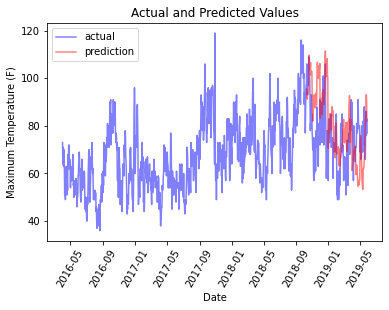

In [36]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [38]:
mean_squared_error(y_test, pred)

263.1340991608696